# MATH50003 (2025–26)
# Lab 7: IV.1 Polynomial Interpolation and Regression and IV.2 SVD and Compression

We  explore polynomial interpolation and regression, and see that when
interpolating at an evenly spaced grid one can encounter issues with convergence.
This is overcome via regression, but we are left with the question of how to
solve the underlying least squares problems.

**Learning Outcomes**

Mathematical knowledge:

1. Vandermonde matrices and least squares.
2. Constructing interpolatory quadrature rules.
3. Issues with interpolation at evenly spaced points with functions with small radii of convergence.
4.

We first load  packages we need including a couple new ones:

In [1]:
# LinearAlgebra contains routines for doing linear algebra
using LinearAlgebra, Plots, Test

## IV.1 Polynomial Interpolation and Regression

We now explore the practical usage of polynomial interpolation and regression.
In particular we will see that polynomial interpolation may fail as the number
of points becomes large.

### IV.1.1 Polynomial Interpolation

A quick-and-dirty way to to do interpolation is to invert the Vandermonde matrix.
That is, for
$$
p(x) = ∑_{k = 0}^{n-1} c_k x^k
$$
and $x_1, …, x_n ∈ ℝ$, we choose $c_k$ so that $p(x_j) = f(x_j)$ for
$j = 1, …, n$. We do so by creating the square Vandermonde matrix
$$
V := \begin{bmatrix} 1 & x_1 & ⋯ & x_1^{n-1} \\
                    ⋮ & ⋮ & ⋱ & ⋮ \\
                    1 & x_n & ⋯ & x_n^{n-1}
                    \end{bmatrix}.
$$
If the function samples are
$$
 𝐟 = \begin{bmatrix} f(x_1) \\ ⋮ \\ f(x_n) \end{bmatrix}
$$
then the coefficients of the interpolatory polynomial
$$
      𝐜 = \begin{bmatrix}
          c_0 \\ ⋮ \\ c_{n-1} \end{bmatrix}
$$
must satisfy $V 𝐜 = 𝐟$.  Thus inverting the Vandermonde matrix tells us the coefficients.

Here we see an example of this using `n` evenly spaced points:

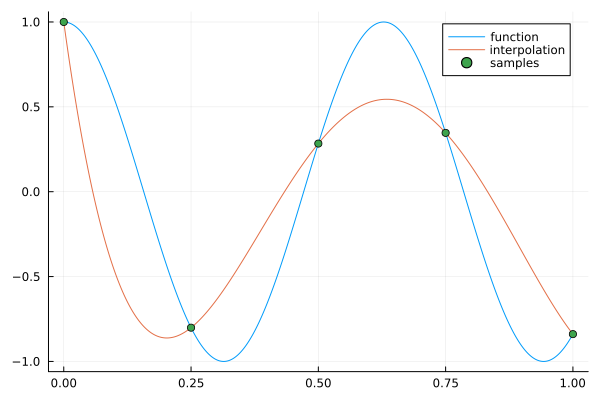

In [2]:
f = x -> cos(10x)
n = 5
𝐱 = range(0, 1; length=n) # evenly spaced points (BAD for interpolation)
V =  [𝐱[j]^k for j = 1:n, k = 0:n-1] # Vandermonde matrix, also can be written as x .^ (0:n)'
𝐟 = f.(𝐱) # evaluate f at x[k], equivalent to [f(x[k]) for k = 1:n]
𝐜 = V \ 𝐟 # invert the Vandermonde matrix and determine the coefficients
p = x -> dot(𝐜, x .^ (0:n-1)) # take a dot product with monomials x .^ 0:n-1 == [x^j for j=0:n-1]
@test p.(𝐱) ≈ V * 𝐜 # evaluating the polynomial on x is the same as applying V


𝐠 = range(0,1; length=1000) # plotting grid, sample a lot more than interpolation points

# To evaluate a polynomial on the plotting grid its faster to create the rectangular Vandermonde matrix associated with that grid:
V_g = [𝐠[j]^k for j = 1:length(𝐠), k = 0:n-1]

plot(𝐠, f.(𝐠); label="function")
plot!(𝐠, V_g*𝐜; label="interpolation")
scatter!(𝐱, f.(𝐱); label="samples")

Whether an interpolation is actually close to a function is a subtle question,
involving properties of the function, distribution of the sample points $x_1,…,x_n$,
and round-off error.
A classic example is:
$$
  f_M(x) = {1 \over M x^2 + 1}
$$
where the choice of $M$ can dictate whether interpolation at evenly spaced points converges.

-------

**Problem 1(a)** Interpolate $1/(4x^2+1)$ and $1/(25x^2 + 1)$ at an evenly spaced grid of $n$
points, plotting the solution at a grid of $1000$ points. For $n = 50$ does your interpolation match
the true function?  Does increasing $n$ to 400 improve the accuracy? How about using `BigFloat`?
Hint: make sure to make your `range` be `BigFloat` valued, e.g., `range(big(-1), big(1); length=n)`.

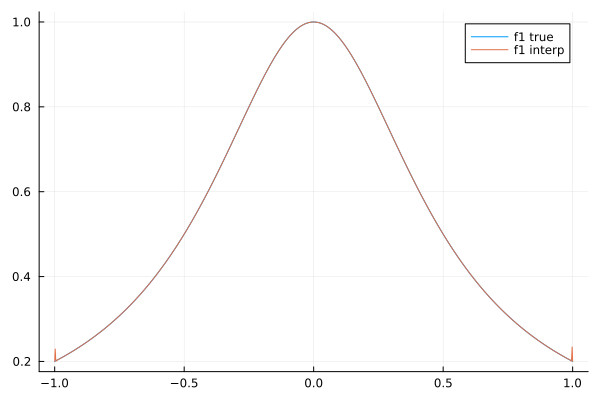

In [42]:
f1 = x -> 1 / (4x^2 + 1)
f2 = x -> 1 / (25x^2 + 1)


n = 400
x = range(-1, 1; length=n)      
g = range(-1, 1; length=1000) 

V  = [x[j]^k for j in 1:n, k in 0:n-1]
Vg = [g[j]^k for j in 1:length(g), k in 0:n-1]


c1 = V \ f1.(x)
c2 = V \ f2.(x)


plot(g, f1.(g); label="f1 true")
plot!(g, Vg*c1; label="f1 interp")

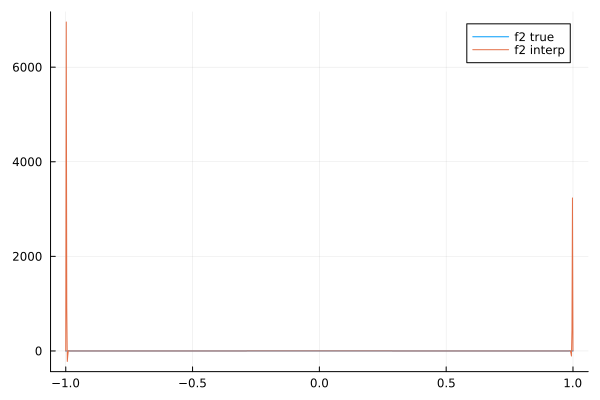

In [41]:
plot(g, f2.(g); label="f2 true")
plot!(g, Vg*c2; label="f2 interp")

**Problem 1(b)** Repeat the previous problem with the points $x_j = \cos θ_j$ where $θ_j$ are $n$ evenly spaced points
between $0$ and $π$. How do the results compare with evenly spaced points? Do you believe interpolation is now converging?

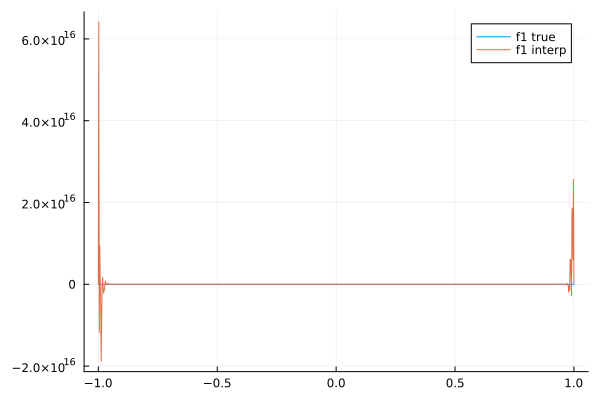

In [78]:
f1 = x -> 1 / (4x^2 + 1)
f2 = x -> 1 / (25x^2 + 1)


n = 400
θ = range(0, big(pi); length=n)   
x = cos.(θ)
g = range(-1, 1; length=1000) 

V  = [x[j]^k for j in 1:n, k in 0:n-1]
Vg = [g[j]^k for j in 1:length(g), k in 0:n-1]


c1 = V \ f1.(x)
c2 = V \ f2.(x)


plot(g, f1.(g); label="f1 true")
plot!(g, Vg*c1; label="f1 interp")

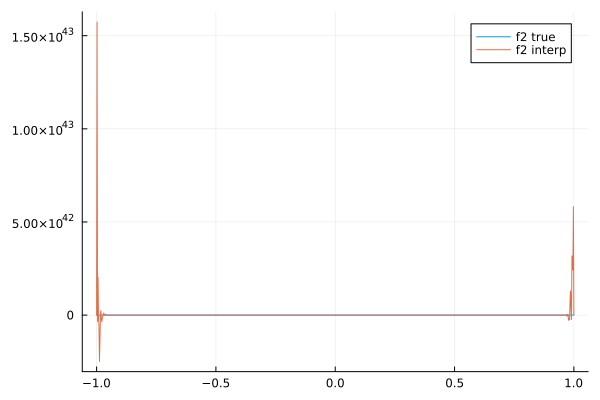

In [79]:
plot(g, f2.(g); label="f2 true")
plot!(g, Vg*c2; label="f2 interp")

### IV.1.2 Interpolatory quadrature rules

An interpolatory quadrature rule consists of interpolating samples of a function and integrating
the polynomial exactly. In the notes we constructed such rules by integrating the Lagrange basis,
however, we can also compute the interpolatory polynomial by inverting the Vandermonde matrix.
Here we explore this construction.

**Problem 2(a)** Complete the following function that computes an interpolatory quadrature
$$
\int_0^1 f(x) {\rm d}x ≈ \int_0^1 p(x) {\rm d}x
$$
where $p(x)$ interpolates the data $𝐟 = [f_1,…,f_n]$ (given as a vector) at the given points $𝐱 = [x_1,…,x_n]$ (given as a vector).
Hint: it is much easier to solve a linear system involving the Vandermonde matrix than to use a Lagrange basis.

In [46]:
function interpolatoryquadrature(f::AbstractVector, x::AbstractVector)
    if length(f) ≠ length(x)
        error("lengths must match")
    end
    n = length(x)
    V  = [x[j]^k for j in 1:n, k in 0:n-1]
    c = V \ f
    sum = 0
    for k = 1:n
        sum += c[k]/k
    end
    sum
end
x = range(0, 1, 10)
@test interpolatoryquadrature(exp.(x), x) ≈ exp(1)-1

Test Passed

**Problem 2(b)**  Plot the error for the number of evenly spaced points $n = 2, 3, …, 100$ for approximating the integrals
$$
∫_0^1 \exp x {\rm d}x  = ℯ - 1, ∫_0^1 {{\rm d} x \over 25x^2 + 1} = {\rm arctan}(5)/5.
$$
How does the convergence behaviour compare with the Trapezium rule? Does the approximation appear to be stable?
Does using `BigFloat` improve the results? (Hint: `range(0,big(1),n)` will make a sequence of `BigFloat` points.)

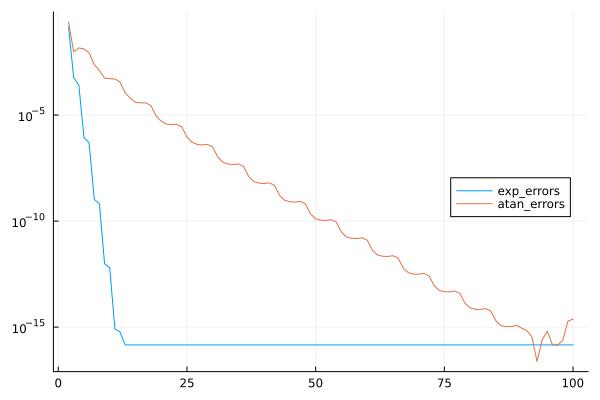

In [74]:
nanabs(x) = x == 0 ? NaN : abs(x)
errors_exp = [nanabs(interpolatoryquadrature(exp.(range(0,big(1), n)), range(0,big(1), n)) + 1 - exp(1)) for n in 2:100]
errors_atan = [nanabs(interpolatoryquadrature(f2.(range(0,big(1), n)), range(0,big(1), n)) - atan(5)/5) for n in 2:100]
plot(2:100, errors_exp; label="exp_errors", yscale=:log10, legend=:right)
plot!(2:100, errors_atan; label="atan_errors")

**Problem 2(c)** Repeat the previous problem with the points $x_j = (\cos θ_j + 1)/2$ where $θ_j$ are $n$ evenly spaced points
between $0$ and $π$. How do the results compare with evenly spaced points?

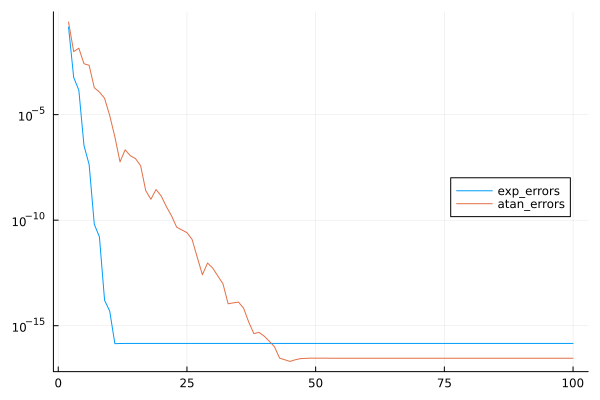

In [77]:
f = y -> (cos(y) + 1)/2
x = n -> f.(range(0, big(pi), n))
errors_exp = [nanabs(interpolatoryquadrature(exp.(x(n)), x(n)) + 1 - exp(1)) for n in 2:100]
errors_atan = [nanabs(interpolatoryquadrature(f2.(x(n)),x(n)) - atan(5)/5) for n in 2:100]
plot(2:100, errors_exp; label="exp_errors", yscale=:log10, legend=:right)
plot!(2:100, errors_atan; label="atan_errors")

**Problem 3** Typically it's more convenient to compute the quadrature weights $w_j$ so that
$$
\int_0^1 f(x) {\rm d}x ≈ \int_0^1 p(x) {\rm d}x = ∑_{j=1}^n w_j f(x_j).
$$
Compute these weights by solving a linear system involving the transpose of the Vandermonde  matrix.

In [ ]:
function interpolatoryweights(x::AbstractVector)
    # TODO: Construct the interpolatory quadrature weights as a vector by solving a linear system involving V'

end

# We test on the example from the notes:
@test interpolatoryweights([0,1/4,1]) ≈ [-1/6, 8/9, 5/18]

------

### IV.1.3 Polynomial regression

To overcome issues with interpolation we will instead use regression: use more points than
the degree of the polynomial. As an example, suppose we want to fit noisy data by a quadratic
$$
p(x) = c₀ + c₁ x + c₂ x^2.
$$
That is, we want to choose $c₀,c₁,c₂$ at data samples $x_1, …, x_m$ so that the following is true:
$$
c₀ + c₁ x_j + c₂ x_j^2 ≈ f_j
$$
where $f_j$ are given by data. We can reinterpret this as a least squares problem: minimise the norm
$$
\left\| \begin{bmatrix} 1 & x_1 & x_1^2 \\ ⋮ & ⋮ & ⋮ \\ 1 & x_m & x_m^2 \end{bmatrix}
\begin{bmatrix} p₀ \\ p₁ \\ p₂ \end{bmatrix} - \begin{bmatrix} f_1 \\ ⋮ \\ f_m \end{bmatrix} \right \|
$$
When a matrix is rectangular `\` solves a least squares problem for us:

In [ ]:
m,n = 100,3

𝐱 = range(0,1; length=m) # 100 points
𝐟 = 2 .+ 𝐱 .+ 2𝐱.^2 .+ 0.1 .* randn.() # Noisy quadratic samples, built with broadcast notation.

V = 𝐱 .^ (0:2)'  # 100 x 3 Vandermonde matrix, equivalent to [ones(m) x x.^2]

𝐜 = V \ 𝐟 # coefficients are, very roughly, [2,1,2]

We can visualise the fit:

In [ ]:
𝐠 =range(0, 1; length=1000)

p = x -> 𝐜[1] + 𝐜[2]x + 𝐜[3]x^2

scatter(𝐱, 𝐟; label="samples", legend=:bottomright)
plot!(𝐠, p.(𝐠); label="quadratic")

-----

**Problem 4** Repeat  Problem 1 but now using _least squares_: instead of interpolating,
use least squares on a large grid: choose the coefficients of a degree $(n-1)$ polynomial so that
$$
    \left\| \begin{bmatrix} p(x_1) \\ ⋮ \\ p(x_m) \end{bmatrix} - \begin{bmatrix} f(x_1) \\ ⋮ \\ f(x_m) \end{bmatrix} \right \|.
$$
is minimised, where $n = 50$ and $m = 500$.
Does this improve the accuracy near the endpoints? Do you think convergence for a least squares approximation
is dictated by the radius of convergence of the corresponding Taylor series?
Hint: use the rectangular Vandermonde matrix to setup the Least squares system. The solution will look extremely similar to Problem 1.

In [ ]:
# TODO: approximate 1/(10x^2 + 1) and 1/(25x^2 + 1) using a least squares system.

## IV.2 Singular Value Decomposition and Matrix Compression

We now explore using the SVD to compress 2D functions sampled at an
evenly spaced grid. This is very much the same as image compression,
but we will see that samples of smooth functions can be approximated by very small rank matrices.
This gives some intuition on why pictures tend to be low rank: most pictures have large portions that are "smooth".

Note in Julia `opnorm(A)` is the induced matrix 2-norm. `norm(A) == norm(vec(A))` is the Fröbenius norm.

The following code samples a function on a grid in the square `[-1,1]^2`
and plots the corresponding pixels:

In [ ]:
f = (x,y) -> exp(-x^2*sin(2y-1))

m,n = 150,100
x = range(-1, 1; length=n)
y = range(-1, 1; length=m)

F = f.(x', y) # equivalent to [f(x[j],y[k]) for k=1:m, j=1:n]

heatmap(x, y, F)

-----

**Problem 5** Complete the following function `fsample(f, m, n)` which takes in a function
and returns its samples on a grid.

In [ ]:
function fsample(f::Function, m::Int, n::Int)
    # TODO: return `f` sampled at an evenly spaced grid on the square [-1, 1]^2
    # with n points in the x direction and
    # n points in the y direction, returning an m × n matrix

end

@test fsample(f, m, n) == F

------
## Singular values of 2D function samples

We will  see experimentally that the singular values
tell us something about the structure functions.  Recall from lectures
the singular value decomposition is a matrix factorization of a
matrix $A ∈ ℝ^{m × n}$ of the form

$$
A = U Σ V^⊤
$$

where $U ∈ ℝ^{m × r}$, $Σ ∈ ℝ^{r × r}$ and $V ∈ ℝ^{n × r}$, where $U$ and $V$
have orthonormal columns and $Σ$ is diagonal.   The singular values are the diagonal entries of $Σ$.

Note that `svdvals(A)` calculates the singular values of a matrix `A`, without calculating
the `U` and `V` components.

-----

**Problem 6(a)** Use `plot(...; yscale=:log10)` and `svdvals` to plot the singular values of
$f(x,y) = \exp(-x^2 \sin(2y-1))$ sampled at a $100 × 150$ evenly spaced grid on $[-1,1]^2$.
At what value does it appear to level off?

**Problem 6(b)** Repeat Problem 2.1, but plotting the first 20 singular values divided by `n`
for `n = m = 50`, `n = m = 100`, and `n = m = 200` on the same figure.  What do you notice?
Hint: recall `plot!` adds a plot to an existing plot.

**Problem 6(c)** Plot the first 50 singular values for `n = m = 200` of
 $\cos(ωxy)$ and $\cos(ωx) \cos(ωy)$ for `ω` equal to 1,10 and 50, on the same figure.
How do the singular values change as the functions become more oscillatory in both examples?

**Problem 6(d)** Plot the singular values of ${\rm sign}(x-y)$ for `n=m=100`
and `n=m=200`.  What do you notice?

-----
## Matrix compression

We now turn to using the SVD to compress matrices. In particular, the following problems explore how we can use
the approximation
$$
A ≈ A_k := \underbrace{\begin{bmatrix} 𝐮_1 | ⋯ | 𝐮_k \end{bmatrix}}_{=: U_k ∈ ℂ^{m × k}} \underbrace{\begin{bmatrix}
σ_1 \\
& ⋱ \\
&& σ_k\end{bmatrix}}_{=: Σ_k ∈ ℂ^{k × k}} \underbrace{\begin{bmatrix} 𝐯_1 | ⋯ | 𝐯_k \end{bmatrix}^⋆}_{=: V_k^⋆ ∈ ℂ^{k × n}}
$$
to approximate a matrix (say, coming from function samples, or pixels of image, or even weights in a Neural Network)
using significantly less data.

-----

**Problem 7(a)** Write a function `svdcompress(A::Matrix, k::Integer)` that returns the best rank-`k` approximation to `A`,
using the in-built `svd` command.

**Problem 7(b)** Compare a `heatmap` plot of `fsample((x,y) -> exp(-x^2*sin(2y-1)), 100, 100)` to its best rank-5 approximation.
What do you observe?

**Problem 7(c)** Write a function `svdcompress_rank(A::Matrix, ε::Real)` that returns the smallest integer `k` so that `opnorm(A - svdcompress(A, k)) ≤ ε`,
which we call the "numerical rank".   (Hint: use the singular values instead of guess-and-check.)

In [ ]:
function svdcompress_rank(A::Matrix, ε::Real)
    # TODO: determine and return rank-k approximation

end
F = fsample((x,y) -> exp(-x^2*sin(2y-1)), 100, 100)
@test svdcompress_rank(F, 1E-10) == 9

**Problem 7(d)** Use `svdcompress_rank` to roughly estimate how the numerical rank of the Hilbert matrix
$$
H_n := \begin{bmatrix} 1 & 1/2 & 1/3 & ⋯ & 1/n \\
                      1/2 & 1/3 & 1/4 & ⋯ & 1/(n+1) \\
                       1/3 & 1/4 & 1/5 & ⋯ & 1/(n+2) \\
                       ⋮ & ⋮ & ⋮ & ⋱ & ⋮ \\
                       1/n & 1/(n+1) & 1/(n+2) & ⋯ & 1/(2n-1)
                       \end{bmatrix}
$$
grows as a function
of $n$ up to $n = 200$, for $ε = 10^{-10}$.
Hint: scaling just the x axis in a plot via `plot(...; xscale=:log10)` will reveal logarithmic
growth.

-----

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*